In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Installation Requirements
# Core packages

!pip install pandas numpy matplotlib scikit-learn category_encoders skforecast xgboost lightgbm properscoring

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from category_encoders.ordinal import OrdinalEncoder
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.recursive import ForecasterRecursiveMultiSeries
import matplotlib.pyplot as plt
import seaborn as sns
from skforecast.model_selection import grid_search_forecaster_multiseries
from sklearn import metrics
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from properscoring import crps_ensemble
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving med_tsb_filter.csv to med_tsb_filter.csv


In [ ]:
# Load data

from google.colab import files
uploaded = files.upload()

df = pd.read_csv('med_tsb_filter.csv')
df.head(5)

,date,hub_id,product_id,quantity_issued
0,2017 Jul,hub_1,product_2,0.000001
1,2017 Aug,hub_1,product_2,1900.000000
2,2017 Sep,hub_1,product_2,1003.000000
3,2017 Oct,hub_1,product_2,1605.000000
4,2017 Nov,hub_1,product_2,2400.000000


In [ ]:
# Make the yearmonth as date format

df['date'] = pd.to_datetime(df['date']) + pd.offsets.MonthEnd(0)
df.head(5)

,date,hub_id,product_id,quantity_issued
0,2017-07-31,hub_1,product_2,0.000001
1,2017-08-31,hub_1,product_2,1900.000000
2,2017-09-30,hub_1,product_2,1003.000000
3,2017-10-31,hub_1,product_2,1605.000000
4,2017-11-30,hub_1,product_2,2400.000000


In [ ]:
# Feature Engineering

df['month'] = df['date'].dt.month  # create month feature

# categorical encoding

enc = OrdinalEncoder()

df[['hub_id_cat', 'product_id_cat']] = enc.fit_transform(df[['hub_id', 'product_id']])
df.head()

,date,hub_id,product_id,quantity_issued,month,hub_id_cat,product_id_cat
0,2017-07-31,hub_1,product_2,0.000001,7,1,1
1,2017-08-31,hub_1,product_2,1900.000000,8,1,1
2,2017-09-30,hub_1,product_2,1003.000000,9,1,1
3,2017-10-31,hub_1,product_2,1605.000000,10,1,1
4,2017-11-30,hub_1,product_2,2400.000000,11,1,1


In [ ]:
# Create unique identifier for series

df['unique_id'] = df['hub_id'] + '_' + df['product_id']
df.head(5)

,date,hub_id,product_id,quantity_issued,month,hub_id_cat,product_id_cat,unique_id
0,2017-07-31,hub_1,product_2,0.000001,7,1,1,hub_1_product_2
1,2017-08-31,hub_1,product_2,1900.000000,8,1,1,hub_1_product_2
2,2017-09-30,hub_1,product_2,1003.000000,9,1,1,hub_1_product_2
3,2017-10-31,hub_1,product_2,1605.000000,10,1,1,hub_1_product_2
4,2017-11-30,hub_1,product_2,2400.000000,11,1,1,hub_1_product_2


In [ ]:
# create series and exogenous data

series = df[['date', 'unique_id', 'quantity_issued']]
exog = df[['date', 'unique_id', 'month', 'hub_id_cat', 'product_id_cat']]

In [ ]:
# Transform series and exog to dictionaries

series_dict = series_long_to_dict(
    data      = series,
    series_id = 'unique_id',
    index     = 'date',
    values    = 'quantity_issued',
    freq      = 'M'
)

exog_dict = exog_long_to_dict(
    data      = exog,
    series_id = 'unique_id',
    index     = 'date',
    freq      = 'M'
)

In [ ]:
# Partition data in train and test

end_train = '2022-06-30'
start_test = pd.to_datetime(end_train) + pd.DateOffset(months=1)  # Add 1 month

series_dict_train = {k: v.loc[:end_train] for k, v in series_dict.items()}
exog_dict_train = {k: v.loc[:end_train] for k, v in exog_dict.items()}
series_dict_test = {k: v.loc[start_test:] for k, v in series_dict.items()}
exog_dict_test = {k: v.loc[start_test:] for k, v in exog_dict.items()}

## xgBoost

In [ ]:
# Fit xgboost forecaster

regressor_xgb = XGBRegressor(tree_method = 'hist',
                             enable_categorical = True)

forecaster_xgb = ForecasterRecursiveMultiSeries(
                 regressor          = regressor_xgb,
                 transformer_series = None,
                 lags               = 4,
                 dropna_from_series = False
             )

forecaster_xgb.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)

forecaster_xgb

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: XGBRegressor 
Lags: [1 2 3 4] 
Window features: None 
Window size: 4 
Series encoding: ordinal 
Series names (levels): 
    hub_10_product_5, hub_11_product_2, hub_11_product_7, hub_13_product_5,
    hub_14_product_5, hub_16_product_2, hub_16_product_5, hub_1_product_2,
    hub_1_product_5, hub_2_product_2, hub_2_product_5, hub_3_product_2,
    hub_5_product_5, hub_6_product_2, hub_8_product_2, hub_8_product_4,
    hub_8_product_5 
Exogenous included: True 
Exogenous names: month, hub_id_cat, product_id_cat 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'hub_10_product_5': ['2017-07-31', '2022-06-30'], 'hub_11_product_2':
    ['2017-07-31', '2022-06-30'], 'hub_11_product_7': ['2017-07-31',
    '2022-06-30'], 'hub_13_product_5': ['2017-07-31', '2022-06-30'],
    'hub_14_product_5': ['2017-07-31', '2022-06-30'], ..., 'hub_5_product_5':
    ['2017-07-31', '2022-06-30'], 'hub_6_product_2': ['2017-07-31',
    '2022-06-30'], 'hub_8_product_2': ['2017-07-31', '2022-06-30'],
    'hub_8_product_4': ['2017-07-31', '2022-06-30'], 'hub_8_product_5':
    ['2017-07-31', '2022-06-30'] 
Training index type: DatetimeIndex 
Training index frequency: ME 
Regressor parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None,
    'enable_categorical': True, 'eval_metric': None, 'feature_types': None,
    'gamma': None, 'grow_policy': None, 'importance_type': None,
    'interaction_constraints': None, 'learning_rate': None, 'max_bin': None,
    'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step':
    None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None,
    'missing': nan, 'monotone_constraints': None, 'multi_strategy': None,
    'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None,
    'random_state': None, 'reg_alpha': None, 'reg_lambda': None,
    'sampling_method': None, 'scale_pos_weight': None, 'subsample': None,
    'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None} 
fit_kwargs: {} 
Creation date: 2025-02-10 21:49:49 
Last fit date: 2025-02-10 21:49:49 
Skforecast version: 0.14.0 
Python version: 3.11.11 
Forecaster id: None

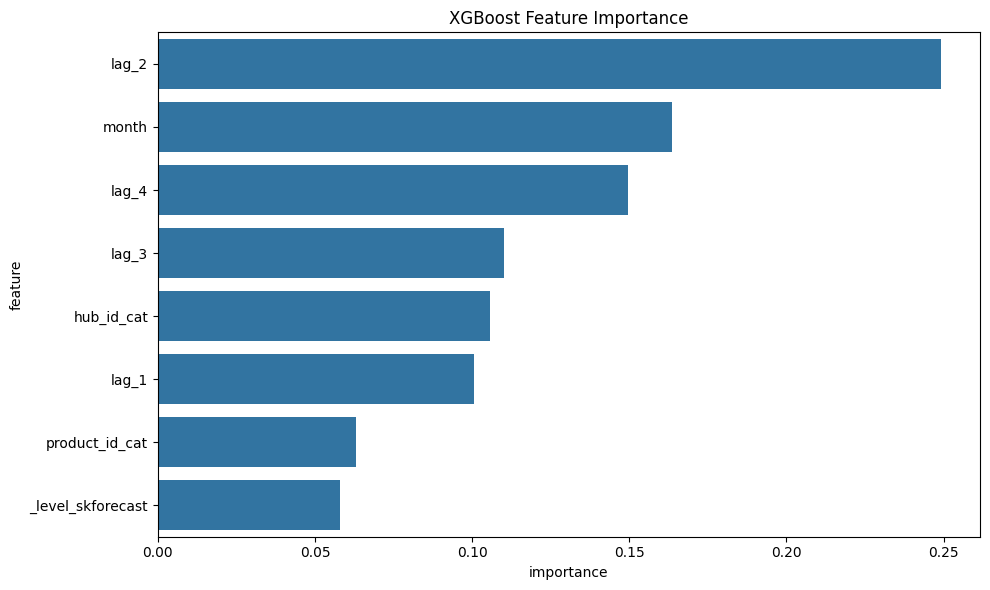

In [ ]:
# Feature importance plot for XGB
plt.figure(figsize=(10, 6))
feat_xgb = forecaster_xgb.get_feature_importances()
sns.barplot(x='importance', y='feature', data=feat_xgb.sort_values('importance', ascending=False).head(10))
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

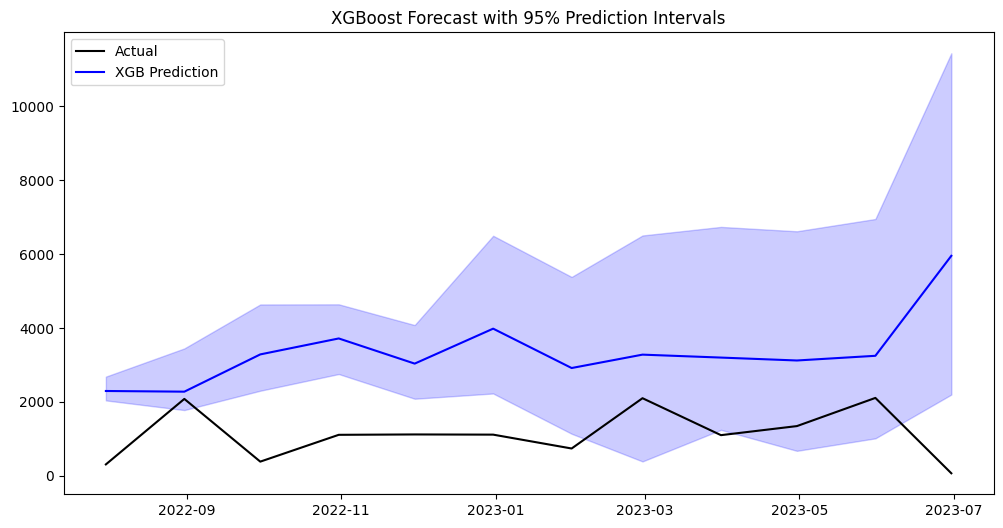

In [ ]:
# XGB predictions and plot
boot = 100
predictions_xgb = forecaster_xgb.predict_bootstrapping(steps=12, exog=exog_dict_test, n_boot=boot)

# Create prediction DF and plot example series
example_series = list(series_dict_test.keys())[2]
xgb_pred_test = predictions_xgb[example_series].copy()

# Calculate statistics
mean_pred = xgb_pred_test.mean(axis=1)
lower_pred = xgb_pred_test.quantile(0.025, axis=1)
upper_pred = xgb_pred_test.quantile(0.975, axis=1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(series_dict_test[example_series], label='Actual', color='black')
plt.plot(mean_pred, label='XGB Prediction', color='blue')
plt.fill_between(mean_pred.index,
                 lower_pred,
                 upper_pred,
                 color='blue', alpha=0.2)
plt.title('XGBoost Forecast with 95% Prediction Intervals')
plt.legend()
plt.show()

In [ ]:
# Create prediciton df

pred_id = list(predictions_xgb.keys())

# Create an empty DataFrame
xgb_pred = pd.DataFrame(columns=['date', 'unique_id', 'model'] + [f'X_{i}' for i in range(boot)])

for i in pred_id:
    xgb_pred_test = predictions_xgb[i]
    xgb_pred_test = xgb_pred_test.reset_index()
    xgb_pred_test.columns = ['date'] + [f'X_{i}' for i in range(boot)]
    xgb_pred_test['unique_id'] = i
    xgb_pred_test['model'] = 'xgb'
    xgb_pred = pd.concat([xgb_pred, xgb_pred_test])

xgb_pred.head()

,date,unique_id,model,X_0,X_1,X_2,X_3,X_4,X_5,X_6,...,X_90,X_91,X_92,X_93,X_94,X_95,X_96,X_97,X_98,X_99
0,2022-07-31,hub_10_product_5,xgb,-159.193115,-417.914307,-165.790283,-519.219177,-444.786377,-582.078125,-403.493408,...,-517.099609,-474.194092,-389.644897,-159.193115,-372.511963,-657.652344,-902.133362,-402.352295,-517.099609,-559.439209
1,2022-08-31,hub_10_product_5,xgb,7859.722656,7805.733398,7875.521484,7875.521484,7885.514160,8119.821777,7889.370117,...,7759.795898,7904.138184,7788.692871,7895.162109,7985.529297,7738.594727,8001.044922,7821.154785,7738.594727,7621.362305
2,2022-09-30,hub_10_product_5,xgb,4755.814453,4790.269531,4650.273926,4820.068359,4552.060547,6468.338867,4690.494141,...,4669.292969,5154.666992,4826.625000,4764.926758,4548.968750,4576.551270,4807.360840,4876.950684,4669.292969,4735.519043
3,2022-10-31,hub_10_product_5,xgb,5661.062500,5955.464355,5882.380371,5407.307617,5953.111328,5217.459961,5641.375977,...,5725.012695,6978.580566,5532.579102,5595.438477,7187.727539,5929.092285,6961.144043,5295.819336,5821.171875,5195.297363
4,2022-11-30,hub_10_product_5,xgb,987.558960,1563.525879,1194.625977,446.891724,1739.977783,8631.224609,1232.693115,...,1206.848267,6428.423828,195.750458,1231.075806,918.446716,3334.928467,161.753052,6814.038086,1391.147827,351.997253


# LightGBM

In [ ]:
# Fit lightgbm forecaster

regressor_lgbm = LGBMRegressor(
                boosting_type = 'gbdt',
                metric = 'mae',
                learning_rate = 0.1,
                num_iterations = 200,
                n_estimators = 100,
                objective = 'poisson')

forecaster_lgbm = ForecasterRecursiveMultiSeries(
                 regressor          = regressor_lgbm,
                 transformer_series = None,
                 lags               = 4,
                 dropna_from_series = False
             )

forecaster_lgbm.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)

forecaster_lgbm

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Number of data points in the train set: 952, number of used features: 8
[LightGBM] [Info] Start training from score 8.350537


============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4] 
Window features: None 
Window size: 4 
Series encoding: ordinal 
Series names (levels): 
    hub_10_product_5, hub_11_product_2, hub_11_product_7, hub_13_product_5,
    hub_14_product_5, hub_16_product_2, hub_16_product_5, hub_1_product_2,
    hub_1_product_5, hub_2_product_2, hub_2_product_5, hub_3_product_2,
    hub_5_product_5, hub_6_product_2, hub_8_product_2, hub_8_product_4,
    hub_8_product_5 
Exogenous included: True 
Exogenous names: month, hub_id_cat, product_id_cat 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'hub_10_product_5': ['2017-07-31', '2022-06-30'], 'hub_11_product_2':
    ['2017-07-31', '2022-06-30'], 'hub_11_product_7': ['2017-07-31',
    '2022-06-30'], 'hub_13_product_5': ['2017-07-31', '2022-06-30'],
    'hub_14_product_5': ['2017-07-31', '2022-06-30'], ..., 'hub_5_product_5':
    ['2017-07-31', '2022-06-30'], 'hub_6_product_2': ['2017-07-31',
    '2022-06-30'], 'hub_8_product_2': ['2017-07-31', '2022-06-30'],
    'hub_8_product_4': ['2017-07-31', '2022-06-30'], 'hub_8_product_5':
    ['2017-07-31', '2022-06-30'] 
Training index type: DatetimeIndex 
Training index frequency: ME 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective':
    'poisson', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0,
    'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0,
    'metric': 'mae', 'num_iterations': 200} 
fit_kwargs: {} 
Creation date: 2025-02-10 21:56:48 
Last fit date: 2025-02-10 21:56:49 
Skforecast version: 0.14.0 
Python version: 3.11.11 
Forecaster id: None

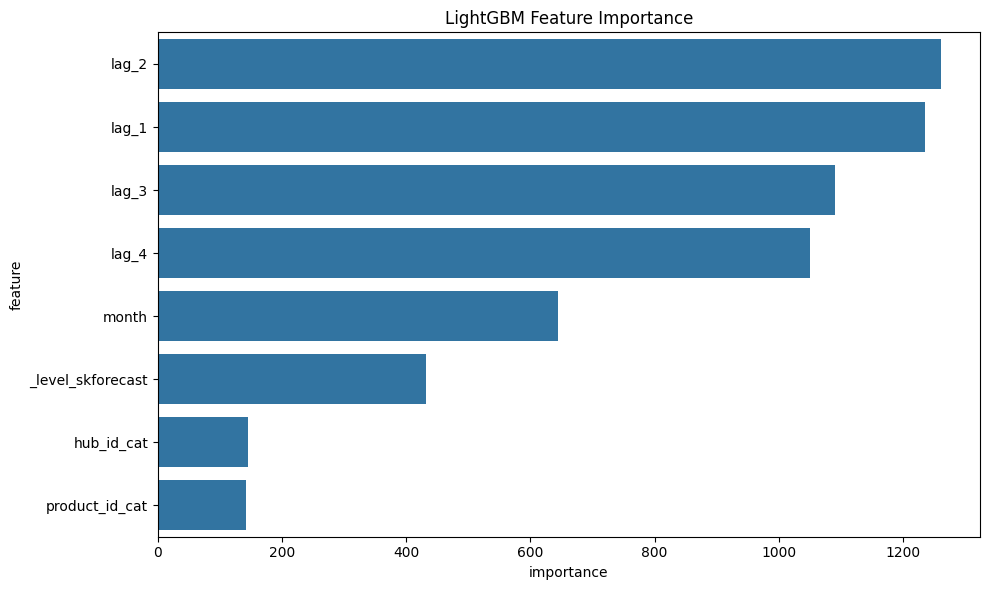

In [ ]:
# Feature importances
feat_lgbm = forecaster_lgbm.get_feature_importances()
feat_lgbm

# Feature importance plot for LGBM
plt.figure(figsize=(10, 6))
feat_lgbm = forecaster_lgbm.get_feature_importances()
sns.barplot(x='importance', y='feature', data=feat_lgbm.sort_values('importance', ascending=False).head(10))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

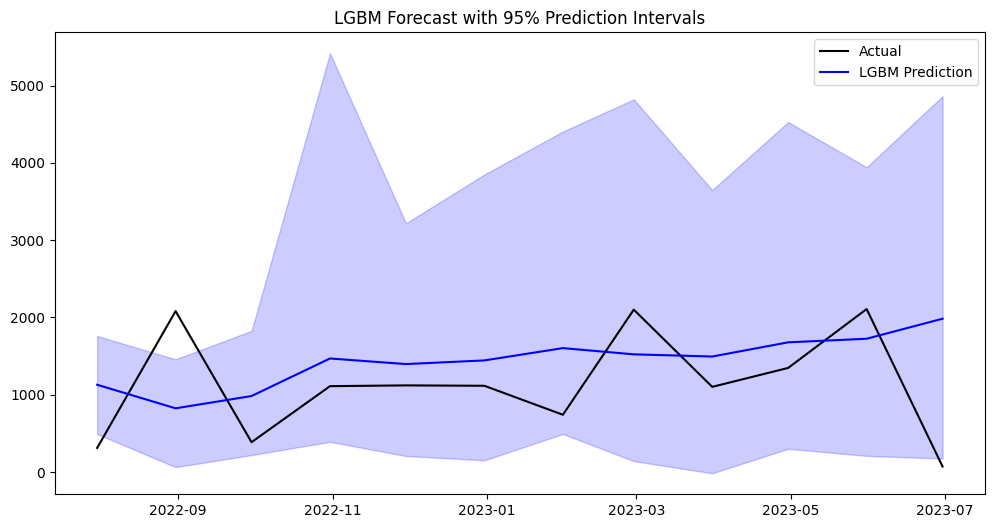

In [ ]:
# LGBM predictions and plot

boot = 100
predictions_lgbm = forecaster_lgbm.predict_bootstrapping(steps=12, exog=exog_dict_test, n_boot=boot)

# Create prediction DF and plot example series
example_series = list(series_dict_test.keys())[2]
lgbm_pred_test = predictions_lgbm[example_series].copy()

# Calculate statistics
mean_pred = lgbm_pred_test.mean(axis=1)
lower_pred = lgbm_pred_test.quantile(0.025, axis=1)
upper_pred = lgbm_pred_test.quantile(0.975, axis=1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(series_dict_test[example_series], label='Actual', color='black')
plt.plot(mean_pred, label='LGBM Prediction', color='blue')
plt.fill_between(mean_pred.index,
                 lower_pred,
                 upper_pred,
                 color='blue', alpha=0.2)
plt.title('LGBM Forecast with 95% Prediction Intervals')
plt.legend()
plt.show()

In [ ]:
# Create prediciton df

pred_id = list(predictions_lgbm.keys())

# Create an empty DataFrame
lgbm_pred = pd.DataFrame(columns=['date', 'unique_id', 'model'] + [f'X_{i}' for i in range(boot)])

for i in pred_id:
    lgbm_pred_test = predictions_lgbm[i]
    lgbm_pred_test = lgbm_pred_test.reset_index()
    lgbm_pred_test.columns = ['date'] + [f'X_{i}' for i in range(boot)]
    lgbm_pred_test['unique_id'] = i
    lgbm_pred_test['model'] = 'lgbm'
    lgbm_pred = pd.concat([lgbm_pred, lgbm_pred_test])

lgbm_pred.head()


,date,unique_id,model,X_0,X_1,X_2,X_3,X_4,X_5,X_6,...,X_90,X_91,X_92,X_93,X_94,X_95,X_96,X_97,X_98,X_99
0,2022-07-31,hub_10_product_5,lgbm,4912.107137,3992.270699,4080.181311,1797.192637,3892.494664,442.082777,4728.996760,...,247.714126,2288.741652,2544.219016,4912.107137,4775.017782,2042.108537,2228.358488,4219.497469,247.714126,3210.917712
1,2022-08-31,hub_10_product_5,lgbm,11487.782677,4626.088245,8949.410155,9544.465391,7678.255094,8414.308833,6764.632412,...,5181.330594,8810.728209,5735.625864,8342.113268,8942.418987,4236.772022,9225.941306,6860.178020,2865.711531,7258.437092
2,2022-09-30,hub_10_product_5,lgbm,10427.499532,2861.841481,6458.336083,4558.335021,3731.598716,1108.248496,3472.767610,...,-1135.029544,8499.520587,5465.251953,9370.221265,6456.627879,2457.981374,6965.376235,5509.694558,-1480.480421,3156.547961
3,2022-10-31,hub_10_product_5,lgbm,12247.126827,5142.961723,9857.923235,10190.324833,10766.719617,11689.809768,5469.170907,...,2916.577819,11244.606492,3175.700719,9180.070184,9090.868759,3061.830817,6650.969943,4769.420615,3707.847118,9731.978905
4,2022-11-30,hub_10_product_5,lgbm,11150.106662,5514.346816,11757.656299,3514.911795,4375.348594,3760.766421,4047.712829,...,-901.274835,10811.581838,3702.710043,10153.225588,9013.719603,1849.214922,7306.799482,1630.731695,3169.703091,3983.130061


## Model Evaluation

In [ ]:
# Calculate metrics for all series
def calculate_metrics(predictions, actuals, train_data):
    mase_list = []
    rmse_list = []
    qs_list = []
    crps_list = []

    for uid in actuals.keys():
        y_true = actuals[uid]
        pred_samples = predictions[uid]
        y_pred = pred_samples.mean(axis=1)

        # MASE calculation
        naive = train_data[uid][:-12].values
        mae_naive = np.mean(np.abs(train_data[uid][12:] - naive))
        mae_model = metrics.mean_absolute_error(y_true, y_pred)
        mase = mae_model / mae_naive

        # RMSE calculation
        rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))

        # Quantile score calculation
        lower = pred_samples.quantile(0.025, axis=1)
        upper = pred_samples.quantile(0.975, axis=1)
        qs = np.mean([2*(0.05*(y_true[i]-upper[i])) if y_true[i]>upper[i] else
                      2*(0.95*(lower[i]-y_true[i])) if y_true[i]<lower[i] else 0
                      for i in range(len(y_true))])

        # CRPS calculation
        crps = np.mean([crps_ensemble(y_true[i], pred_samples.iloc[i].values)
                       for i in range(len(y_true))])

        mase_list.append(mase)
        rmse_list.append(rmse)
        qs_list.append(qs)
        crps_list.append(crps)

    return (np.mean(mase_list), np.mean(rmse_list),
            np.mean(qs_list), np.mean(crps_list))

In [ ]:
# Calculate metrics for both models
xgb_mase, xgb_rmse, xgb_qs, xgb_crps = calculate_metrics(predictions_xgb, series_dict_test, series_dict_train)
lgbm_mase, lgbm_rmse, lgbm_qs, lgbm_crps = calculate_metrics(predictions_lgbm, series_dict_test, series_dict_train)

# Print results
print("Model Comparison:")
print(f"\nXGBoost Metrics:")
print(f"Average MASE: {xgb_mase:.3f}")
print(f"Average RMSE: {xgb_rmse:.3f}")
print(f"Average Quantile Score: {xgb_qs:.3f}")
print(f"Average CRPS: {xgb_crps:.3f}")

print(f"\nLightGBM Metrics:")
print(f"Average MASE: {lgbm_mase:.3f}")
print(f"Average RMSE: {lgbm_rmse:.3f}")
print(f"Average Quantile Score: {lgbm_qs:.3f}")
print(f"Average CRPS: {lgbm_crps:.3f}")

Model Comparison:

XGBoost Metrics:
Average MASE: 1.218
Average RMSE: 4878.992
Average Quantile Score: 1151.738
Average CRPS: 3548.056

LightGBM Metrics:
Average MASE: 1.061
Average RMSE: 4953.944
Average Quantile Score: 310.234
Average CRPS: 3498.346


## NIXTLA - TimeGPT

# Get API key from Nixtla
1. Visit https://nixtla.io/
2. Sign up for free account
3. Navigate to API Keys section
4. Create new key and copy it

In [ ]:
!pip install nixtla

In [ ]:
# Load libraries
from nixtla import NixtlaClient

In [ ]:
# Initialize Nixtla client

nixtla_client = NixtlaClient(api_key='your_api_key_here')

In [ ]:
# Initialize Nixtla client

nixtla_client = NixtlaClient(api_key='nixtla-tok-fQ023pkMcbq0hsxZCUNUyHruTjNHOe07YkG6PIdlUduZaQeyXG18s1e59Fjt2FieAZBWOPxBKTgEeJeD')

In [ ]:
# Since we already have done the feature engineering, we dont need to do it again
# Create unique identifier and rename columns for TimeGPT
df_timegpt = df.rename(columns={'date': 'ds', 'quantity_issued': 'y'}).drop(columns=['hub_id', 'product_id'])
df_timegpt.head()

,ds,y,month,hub_id_cat,product_id_cat,unique_id
0,2017-07-31,0.000001,7,1,1,hub_1_product_2
1,2017-08-31,1900.000000,8,1,1,hub_1_product_2
2,2017-09-30,1003.000000,9,1,1,hub_1_product_2
3,2017-10-31,1605.000000,10,1,1,hub_1_product_2
4,2017-11-30,2400.000000,11,1,1,hub_1_product_2


In [ ]:
# Split data into train-test
end_train = '2022-06-30'
train_df = df_timegpt[df_timegpt['ds'] <= end_train]
test_df = df_timegpt[df_timegpt['ds'] > end_train]

In [ ]:
# TimeGPT Base Model
timegpt_fcst =  nixtla_client.forecast(
    df=train_df,
    h=len(test_df['ds'].unique()),
    freq='M',
    level=[90, 95]  # 90% and 95% prediction intervals
)

timegpt_fcst.head()

,unique_id,ds,TimeGPT,TimeGPT-hi-90,TimeGPT-hi-95,TimeGPT-lo-90,TimeGPT-lo-95
0,hub_10_product_5,2022-07-31,10274.173,20216.424,20888.344,331.9226,-339.99817
1,hub_10_product_5,2022-08-31,11620.866,15698.777,15729.170,7542.9550,7512.56250
2,hub_10_product_5,2022-09-30,12079.378,18037.064,18252.912,6121.6910,5905.84400
3,hub_10_product_5,2022-10-31,9893.031,17021.365,17728.096,2764.6978,2057.96600
4,hub_10_product_5,2022-11-30,10195.425,25102.934,25370.060,-4712.0830,-4979.21140


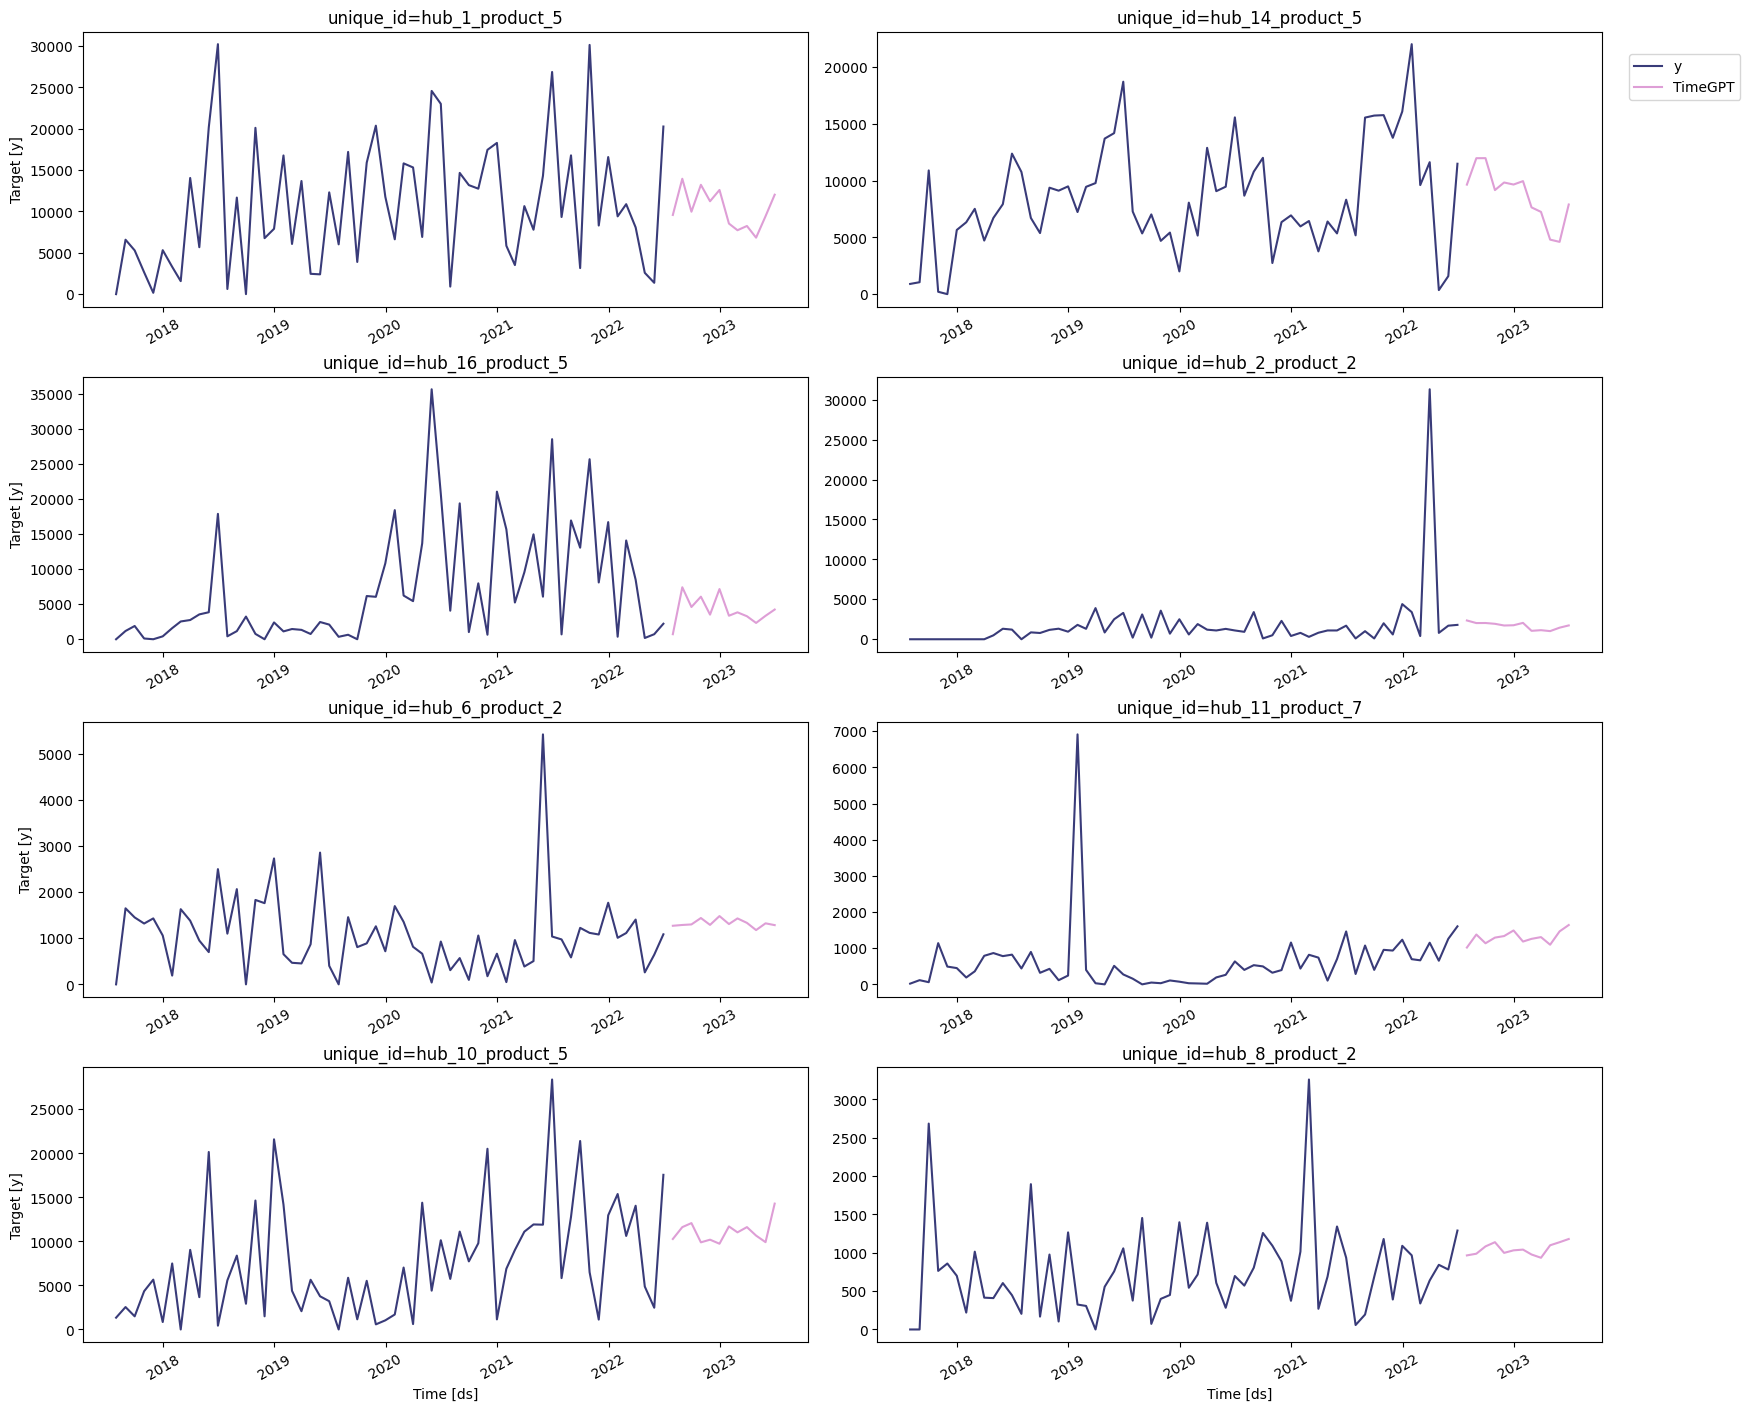

In [ ]:
# plotting

nixtla_client.plot(train_df, timegpt_fcst, time_col='ds', target_col='y')

In [ ]:
# TimeGPT with Exogenous Variables

# Prepare exogenous data
exog_features = ['month', 'hub_id_cat', 'product_id_cat']

# Future exogenous variables (from your test set)
future_exog = test_df[['unique_id', 'ds'] + exog_features]

timegpt_reg_fcst = nixtla_client.forecast(
    df=train_df,
    X_df=future_exog,
    h=len(test_df['ds'].unique()),
    freq='M',
    level=[90, 95]
)

timegpt_reg_fcst

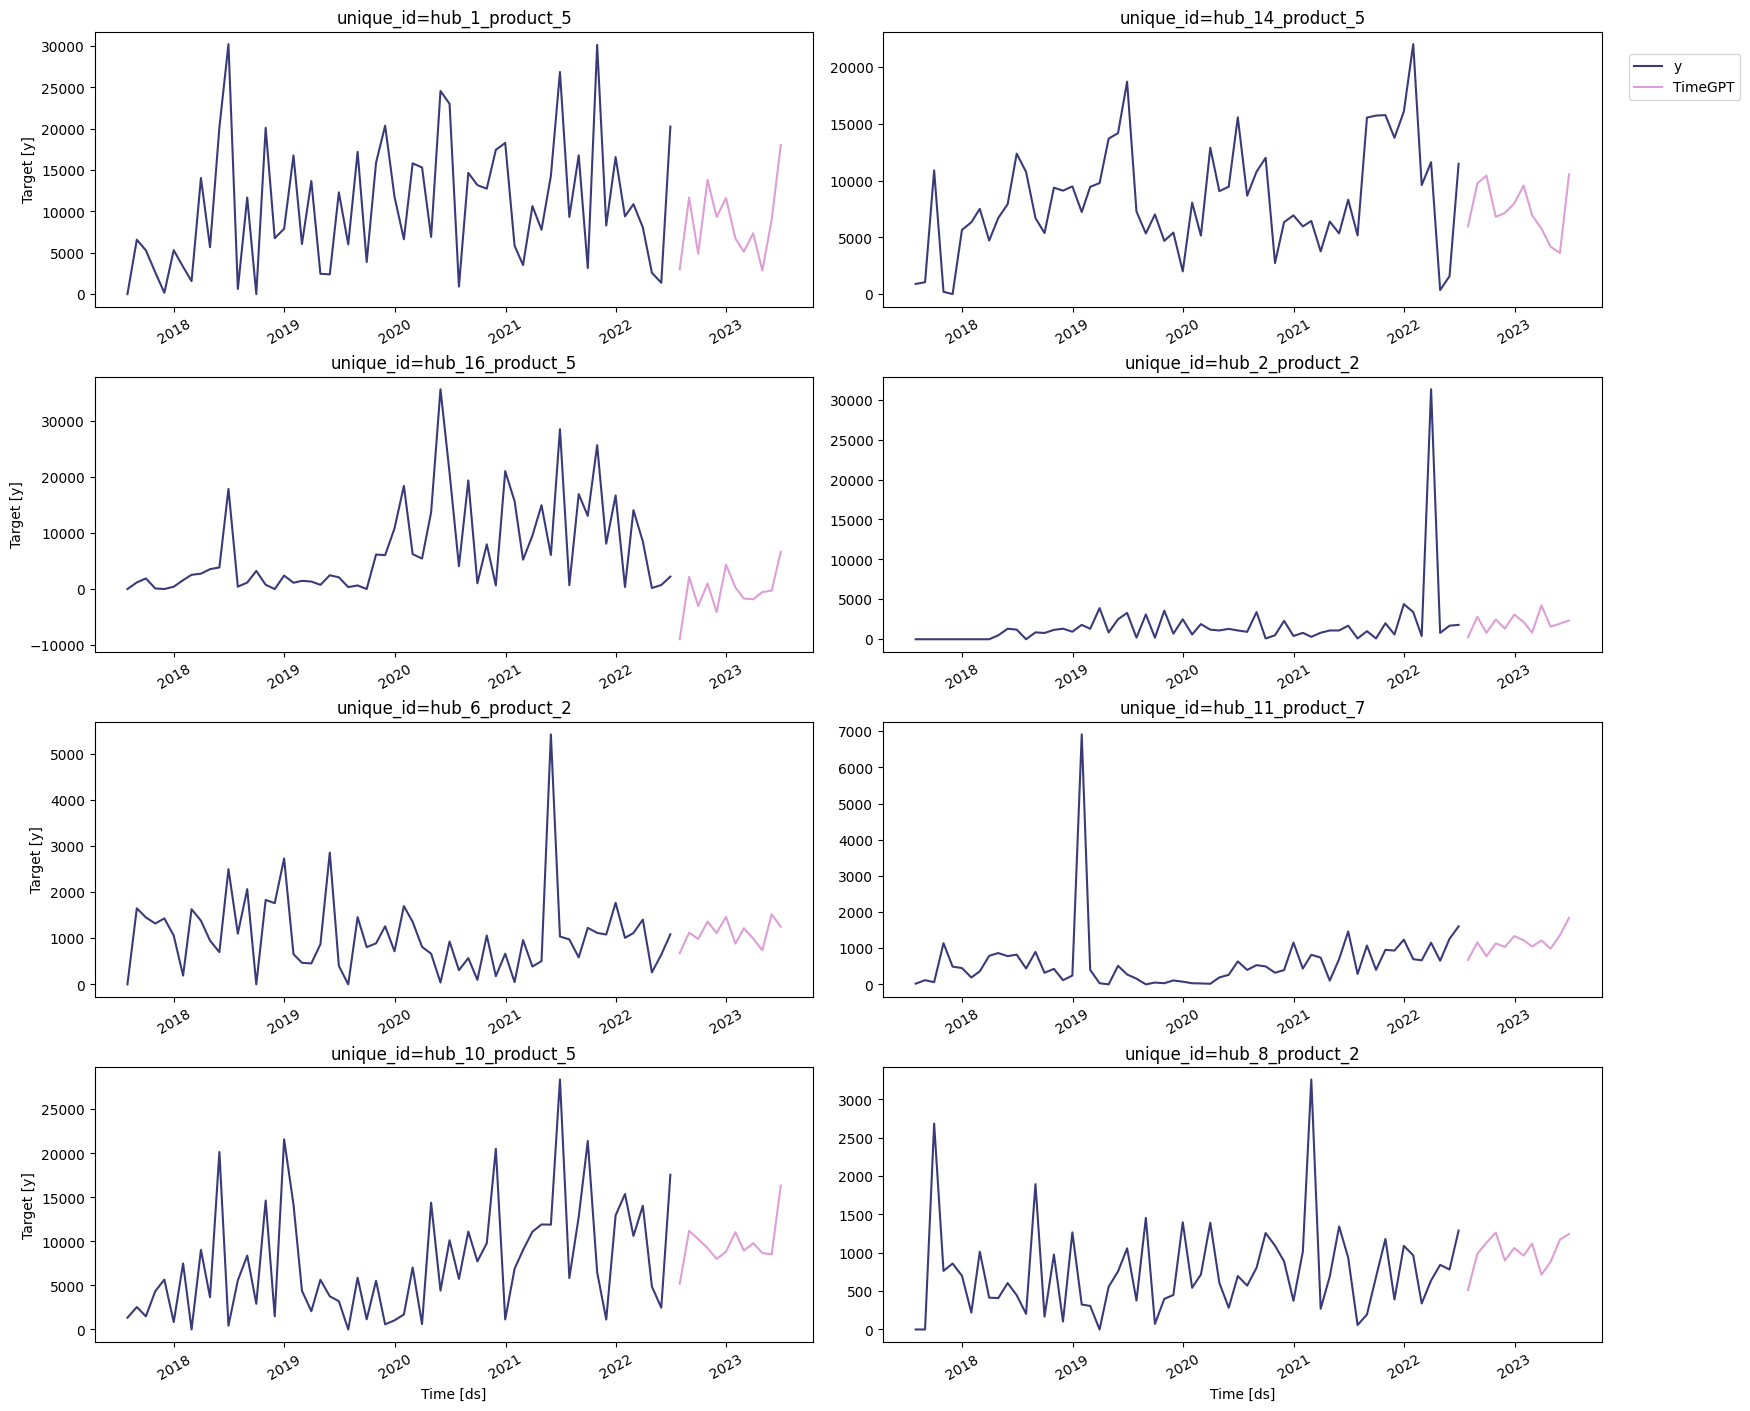

In [ ]:
# plotting

nixtla_client.plot(train_df, timegpt_reg_fcst, time_col='ds', target_col='y')

In [ ]:
# Error Metrics
def calculate_mase(y_true, y_pred, y_train, seasonality=12):
    naive = y_train[:-seasonality].values
    mae_naive = np.mean(np.abs(y_train[seasonality:] - naive))
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

def calculate_quantile_score(y_true, lower, upper, alpha=0.05):
    scores = []
    for y, l, u in zip(y_true, lower, upper):
        if y < l:
            scores.append(2 * (1 - alpha) * (l - y))
        elif y > u:
            scores.append(2 * alpha * (y - u))
        else:
            scores.append(0)
    return np.mean(scores)

def evaluate_timegpt(fcst_df, test_df, train_df):
    merged = pd.merge(test_df, fcst_df, on=['unique_id', 'ds'], suffixes=('_true', '_pred'))

    metrics = []
    for uid in merged['unique_id'].unique():
        subset = merged[merged['unique_id'] == uid]
        y_true = subset['y_true']
        y_pred = subset['y_pred']
        lower = subset['lo95']
        upper = subset['hi95']

        # Get training data for MASE
        y_train = train_df[train_df['unique_id'] == uid]['y']

        metrics.append({
            'unique_id': uid,
            'MASE': calculate_mase(y_true, y_pred, y_train),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'Quantile_Score': calculate_quantile_score(y_true, lower, upper)
        })

    return pd.DataFrame(metrics)

## Perfomance evaluation

In [ ]:
def calculate_metrics(predictions_df, test_df, train_df):
    mase_list = []
    rmse_list = []
    qs_list = []

    # Merge predictions with actual values
    merged = pd.merge(test_df, predictions_df, on=['unique_id', 'ds'])

    for uid in merged['unique_id'].unique():
        # Filter data for current series
        series_data = merged[merged['unique_id'] == uid]
        train_series = train_df[train_df['unique_id'] == uid]

        y_true = series_data['y']
        y_pred = series_data['TimeGPT']
        lower = series_data['TimeGPT-lo-95']
        upper = series_data['TimeGPT-hi-95']

        # MASE calculation
        naive = train_series['y'].iloc[:-12].values
        mae_naive = np.mean(np.abs(train_series['y'].iloc[12:] - naive))
        mae_model = mean_absolute_error(y_true, y_pred)
        mase = mae_model / mae_naive

        # RMSE calculation
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Quantile score calculation (95% PI)
        qs = np.mean([
            0.05 * (lower.iloc[i] - y_true.iloc[i]) if y_true.iloc[i] < lower.iloc[i] else
            0.05 * (y_true.iloc[i] - upper.iloc[i]) if y_true.iloc[i] > upper.iloc[i] else 0
            for i in range(len(y_true))
        ])

        mase_list.append(mase)
        rmse_list.append(rmse)
        qs_list.append(qs)

    return {
        'MASE': np.mean(mase_list),
        'RMSE': np.mean(rmse_list),
        'Quantile_Score': np.mean(qs_list)
    }

In [ ]:
# Calculate metrics for base model
base_metrics = calculate_metrics(timegpt_fcst, test_df, train_df)

# Calculate metrics for regressor model
reg_metrics = calculate_metrics(timegpt_reg_fcst, test_df, train_df)

# Display comparison
print("Model Comparison:")
print(f"Metric\t\tBase Model\tRegressor Model")
print(f"MASE\t\t{base_metrics['MASE']:.3f}\t\t{reg_metrics['MASE']:.3f}")
print(f"RMSE\t\t{base_metrics['RMSE']:.3f}\t\t{reg_metrics['RMSE']:.3f}")
print(f"Quantile Score\t{base_metrics['Quantile_Score']:.3f}\t\t{reg_metrics['Quantile_Score']:.3f}")

Model Comparison:
Metric		Base Model	Regressor Model
MASE		1.019		1.125
RMSE		4261.135		5016.053
Quantile Score	41.892		57.571
